# Allenamento baseline ResNet50 per Rotazione (Pose Estimation)

Questo notebook permette di:
1. **Import e Setup**
2. **Carica dataset LineMOD** con split ufficiale train/test
3. **Inizializza PoseEstimatorBaseline** (ResNet-50 backbone, solo rotazione)
4. **Training**
5. **Valutazione su test set** (solo metriche di rotazione)

Esegui sempre sezione 1 e 2 per configurare l'ambiente. Poi scegli:
- **Training completo**
- **Test modello già trainato -> Punto 5**

## 1. Import e Setup

In [1]:
import sys
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import torch
from tqdm import tqdm
import yaml
import random
import pandas as pd
import matplotlib.pyplot as plt
import yaml
import matplotlib.pyplot as plt

# Importa il config per usare path e file in altre cartelle
sys.path.insert(0, str(Path.cwd().parent))  # Aggiungi parent al path
from config import Config
from utils.transforms import quaternion_to_rotation_matrix_batch
from dataset.linemod_pose import create_pose_dataloaders
from models.pose_estimator_baseline import PoseEstimatorBaseline
from utils.losses import PoseLossBaseline
from utils.metrics import compute_add_batch_rotation_only, load_all_models, load_models_info
from utils.transforms import quaternion_to_rotation_matrix_batch

# Usa PROJECT_ROOT dal config
project_root = Config.PROJECT_ROOT
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

# Configura matplotlib per notebook
%matplotlib inline

print(f"✅ Setup completato")
print(f"📂 Project root: {project_root}")
print(f"🎯 Dataset: LineMOD")
print(f"🖥️  Device: {Config.DEVICE}")
print(f"📊 Image size: {Config.POSE_IMAGE_SIZE}x{Config.POSE_IMAGE_SIZE}")
print(f"🔢 Batch size: {Config.POSE_BATCH_SIZE}")

Cache Strategy: full
Numworkers set to 0
Numworkers set to 0
✅ Setup completato
📂 Project root: /Users/nicolotermine/zMellow/GitHub-Poli/Polito/polito-aml-6D_pose_estimation
🎯 Dataset: LineMOD
🖥️  Device: mps
📊 Image size: 224x224
🔢 Batch size: 64


## 2. Carica dataset LineMOD

In [ ]:
# Carica dataset con split ufficiale train/test
print("📦 Caricamento PoseDataset con split ufficiale...\n")

train_loader, val_loader, test_loader = create_pose_dataloaders(
    dataset_root=Config.LINEMOD_ROOT,
    batch_size=Config.POSE_BATCH_SIZE,
    crop_margin=Config.POSE_CROP_MARGIN,
    output_size=Config.POSE_IMAGE_SIZE,
    num_workers=Config.NUM_WORKERS_POSE
)

print(f"✅ Dataset caricato:")
print(f"   Train batches: {len(train_loader)} (batch_size={Config.POSE_BATCH_SIZE})")
print(f"   Test batches: {len(test_loader)}")
print(f"   Train samples: ~{len(train_loader) * Config.POSE_BATCH_SIZE}")
print(f"   Test samples: ~{len(test_loader) * Config.POSE_BATCH_SIZE}")
print(f"   Crop margin: {Config.POSE_CROP_MARGIN * 100:.0f}%")
print(f"   Output size: {Config.POSE_IMAGE_SIZE}x{Config.POSE_IMAGE_SIZE}")
print(f"   Workers: {Config.NUM_WORKERS_POSE} (adaptive per {Config.DEVICE})")

📦 Caricamento PoseDataset con split ufficiale...

✅ Dataset caricato:
   Train batches: 38 (batch_size=64)
   Test batches: 210
   Train samples: ~2432
   Test samples: ~13440
   Crop margin: 15%
   Output size: 224x224
   Workers: 0 (adaptive per mps)


### Visualizza immagini training set con info su rotazione


🖼️  Visualizzazione sample del training set (immagini già croppate)



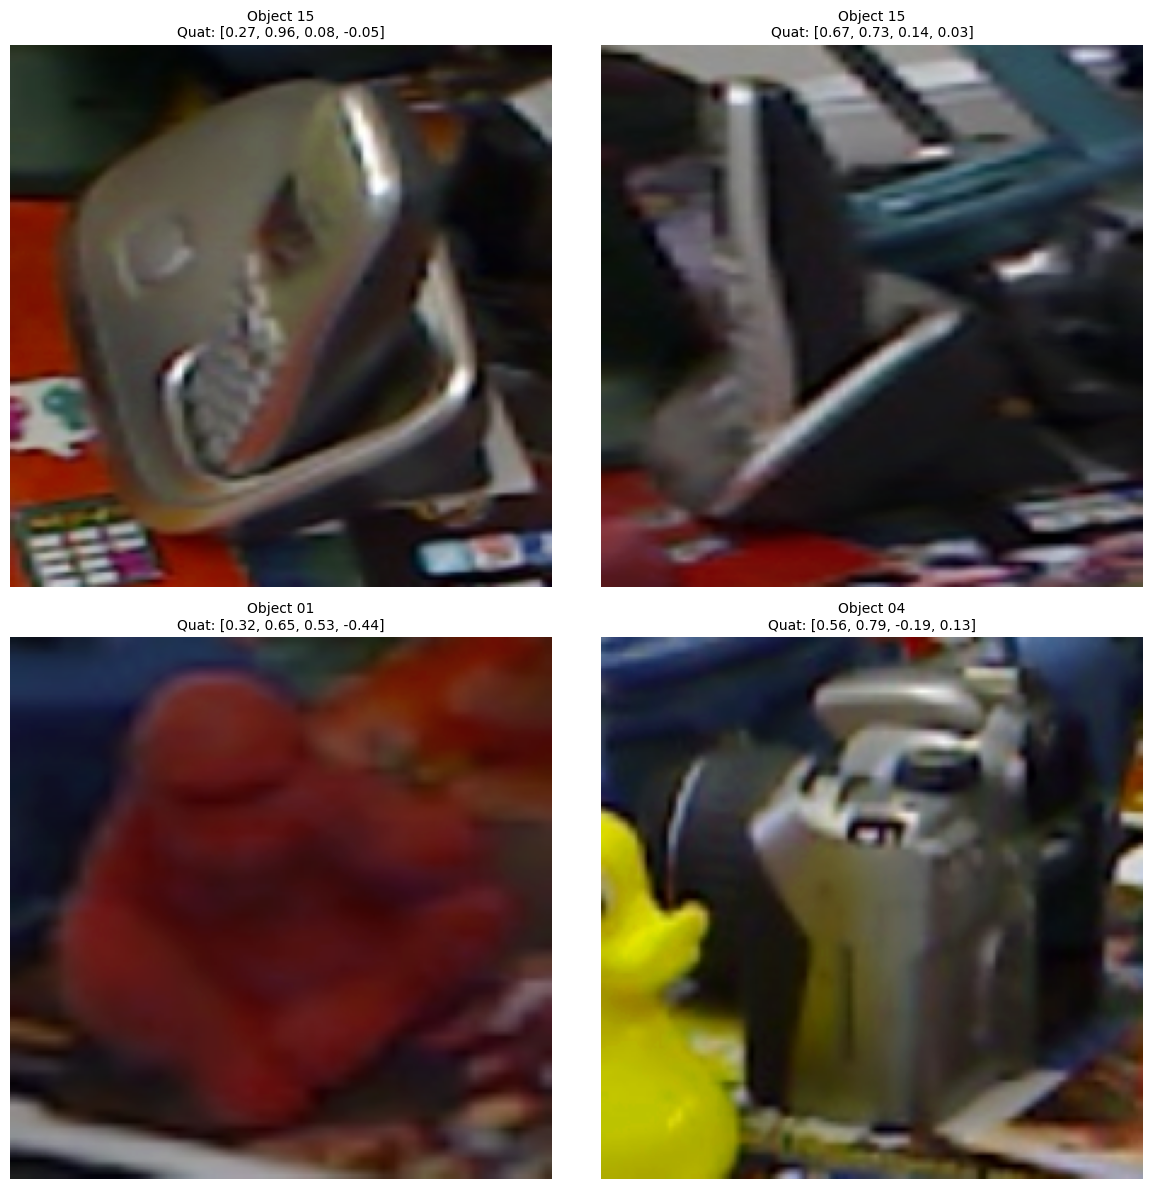

✅ Visualizzazione completata!
   Le immagini sono già croppate dal dataset.
   Quaternion normalizzato (||q|| = 1)


In [3]:
# Visualizza alcuni sample del dataset (le immagini sono già croppate)
print("\n🖼️  Visualizzazione sample del training set (immagini già croppate)\n")
batch = next(iter(train_loader))
images = batch['rgb'] if 'rgb' in batch else batch['rgb_crop']  # [B, 3, H, W] o [B, 3, 224, 224]
quaternions = batch['quaternion']  # [B, 4]
obj_ids = batch['obj_id']  # [B]

fig, axes = plt.subplots(2, 2, figsize=(12, 12))
axes = axes.flatten()

for i in range(min(4, len(images))):
    img = images[i].permute(1, 2, 0).cpu().numpy()
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = img * std + mean
    img = np.clip(img, 0, 1)
    quat = quaternions[i].cpu().numpy()
    obj_id = obj_ids[i].item()
    axes[i].imshow(img)
    axes[i].set_title(
        f"Object {obj_id:02d}\n"
        f"Quat: [{quat[0]:.2f}, {quat[1]:.2f}, {quat[2]:.2f}, {quat[3]:.2f}]",
        fontsize=10
    )
    axes[i].axis('off')

plt.tight_layout()
plt.show()

print(f"✅ Visualizzazione completata!")
print(f"   Le immagini sono già croppate dal dataset.")
print(f"   Quaternion normalizzato (||q|| = 1)")

## 3. Inizializza Modello PoseEstimatorBaseline

In [4]:
print("🤖 Inizializzazione PoseEstimatorBaseline...\n")

model = PoseEstimatorBaseline(
    pretrained=True,
    dropout=Config.POSE_DROPOUT,
    freeze_backbone=False
).to(Config.DEVICE)

print(f"✅ Modello inizializzato:")
print(f"   Backbone: ResNet-50 (pretrained ImageNet)")
print(f"   Dropout: {Config.POSE_DROPOUT}")
print(f"   Output: 4D quaternion (rotazione)")

total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"\n📊 Parametri del modello:")
print(f"   Parametri totali: {total_params:,}")
print(f"   Parametri trainable: {trainable_params:,}")
print(f"   Percentuale trainable: {100 * trainable_params / total_params:.1f}%")

🤖 Inizializzazione PoseEstimatorBaseline...



/Users/nicolotermine/Library/Caches/pypoetry/virtualenvs/polito-aml-6d-pose-estimation-LevBIKLF-py3.13/lib/python3.13/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/nicolotermine/Library/Caches/pypoetry/virtualenvs/polito-aml-6d-pose-estimation-LevBIKLF-py3.13/lib/python3.13/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


✅ PoseEstimatorBaseline initialized (BASELINE MODEL)
   Backbone: resnet50 (pretrained=True, frozen=False)
   Feature dim: 2048
   Output: 4 values (quaternion only)
   Translation: Computed with Pinhole Camera Model (NOT learned)
   Dropout: 0.5
✅ Modello inizializzato:
   Backbone: ResNet-50 (pretrained ImageNet)
   Dropout: 0.5
   Output: 4D quaternion (rotazione)

📊 Parametri del modello:
   Parametri totali: 26,136,132
   Parametri trainable: 26,136,132
   Percentuale trainable: 100.0%


## 4. Training (solo rotazione)

In [5]:
NAME = f"test_rotationonly_1"
EPOCHS = Config.POSE_EPOCHS
LR = Config.POSE_LR
ACCUMULATION_STEPS = Config.ACCUMULATION_STEPS

# Percorso standardizzato per i pesi
checkpoint_dir = Config.CHECKPOINT_DIR / "pose" / NAME
checkpoint_weights_dir = checkpoint_dir / "weights"
checkpoint_weights_dir.mkdir(parents=True, exist_ok=True)
best_path = checkpoint_weights_dir / "best.pt"
last_path = checkpoint_weights_dir / "last.pt"

# Salva gli argomenti di training in args.yaml
args_dict = {
    'epochs': EPOCHS,
    'learning_rate': LR,
    'accumulation_steps': ACCUMULATION_STEPS,
    'batch_size': Config.POSE_BATCH_SIZE,
    'dropout': Config.POSE_DROPOUT,
    'freeze_backbone': False,
    'device': str(Config.DEVICE),
    'crop_margin': Config.POSE_CROP_MARGIN,
    'output_size': Config.POSE_IMAGE_SIZE,
    'weight_decay': Config.POSE_WEIGHT_DECAY
}
with open(checkpoint_dir / "args.yaml", "w") as f:
    yaml.dump(args_dict, f)

criterion = PoseLossBaseline()

optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=Config.POSE_WEIGHT_DECAY)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, min_lr=1e-7)

history = {'train_loss': []}
best_loss = float('inf')

for epoch in range(EPOCHS):
    model.train()
    epoch_loss = 0
    optimizer.zero_grad()
    pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{EPOCHS}')
    for batch_idx, batch in enumerate(pbar):
        images = batch['rgb_crop'].to(Config.DEVICE)
        gt_quaternion = batch['quaternion'].to(Config.DEVICE)
        pred_quaternion = model(images)
        loss_dict = criterion(pred_quaternion, gt_quaternion)
        loss = loss_dict['total'] / ACCUMULATION_STEPS
        loss.backward()
        if (batch_idx + 1) % ACCUMULATION_STEPS == 0 or (batch_idx + 1) == len(train_loader):
            optimizer.step()
            optimizer.zero_grad()
        epoch_loss += loss.item() * ACCUMULATION_STEPS
        pbar.set_postfix({'loss': f"{loss.item() * ACCUMULATION_STEPS:.4f}"})
    avg_loss = epoch_loss / len(train_loader)
    history['train_loss'].append(avg_loss)
    scheduler.step(avg_loss)
    print(f"Epoch {epoch+1}: loss={avg_loss:.4f}")
    # Salva sempre il modello last
    torch.save(model.state_dict(), last_path)
    if avg_loss < best_loss:
        best_loss = avg_loss
        torch.save(model.state_dict(), best_path)
        print(f"💾 Best model salvato in: {best_path}")
print("✅ Training completato!")

# Salva la curva di training loss in results.csv
results_df = pd.DataFrame({'epoch': list(range(1, len(history['train_loss'])+1)), 'train_loss': history['train_loss']})
results_df.to_csv(checkpoint_dir / "results.csv", index=False)


✅ PoseLossBaseline initialized (BASELINE MODEL)
   Loss: Only rotation (quaternion geodesic distance)
   Translation: Computed with Pinhole (not part of loss)


Epoch 1/50: 100%|██████████| 38/38 [00:49<00:00,  1.30s/it, loss=0.6962]


Epoch 1: loss=0.9387
💾 Best model salvato in: /Users/nicolotermine/zMellow/GitHub-Poli/Polito/polito-aml-6D_pose_estimation/checkpoints/pose/test_rotationonly_1/weights/best.pt


Epoch 2/50: 100%|██████████| 38/38 [00:40<00:00,  1.08s/it, loss=0.6539]


Epoch 2: loss=0.7389
💾 Best model salvato in: /Users/nicolotermine/zMellow/GitHub-Poli/Polito/polito-aml-6D_pose_estimation/checkpoints/pose/test_rotationonly_1/weights/best.pt


Epoch 3/50: 100%|██████████| 38/38 [00:40<00:00,  1.07s/it, loss=0.4960]


Epoch 3: loss=0.5719
💾 Best model salvato in: /Users/nicolotermine/zMellow/GitHub-Poli/Polito/polito-aml-6D_pose_estimation/checkpoints/pose/test_rotationonly_1/weights/best.pt


Epoch 4/50:   0%|          | 0/38 [00:01<?, ?it/s]


KeyboardInterrupt: 

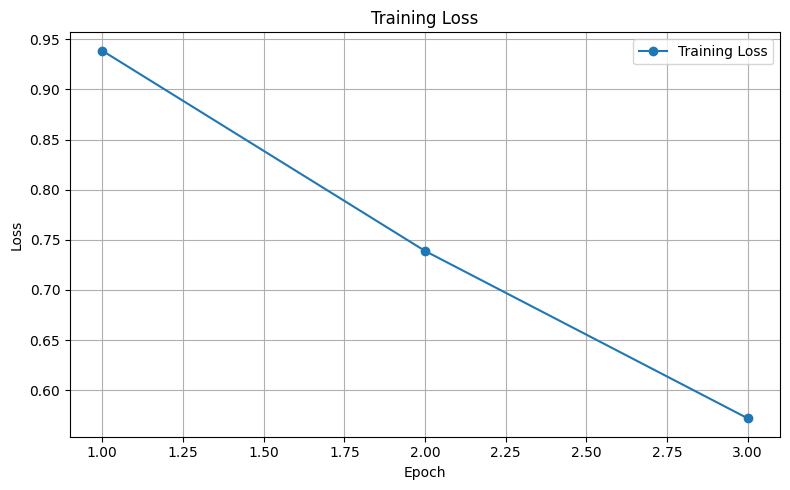

Ultima training loss: 0.5719


In [6]:
# Grafico training loss e validation loss

# Assicurati che 'history' contenga anche 'val_loss' se vuoi visualizzare la curva di validazione
train_loss = history.get('train_loss', [])
val_loss = history.get('val_loss', None)

epochs = range(1, len(train_loss) + 1)
plt.figure(figsize=(8, 5))
plt.plot(epochs, train_loss, label='Training Loss', marker='o')
if val_loss is not None:
    plt.plot(epochs, val_loss, label='Validation Loss', marker='s')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss' + (' e Validation Loss' if val_loss is not None else ''))
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

if val_loss is not None:
    print(f"Ultima training loss: {train_loss[-1]:.4f} | Ultima validation loss: {val_loss[-1]:.4f}")
else:
    print(f"Ultima training loss: {train_loss[-1]:.4f}")

### Visualizza predizione su batch immagini

In [7]:
# Carica il modello trained (se necessario)
NAME = f"pose_baseline_train{Config.POSE_EPOCHS}"
checkpoint_weights_dir = Config.CHECKPOINT_DIR / "pose" / NAME / "weights"
best_path = checkpoint_weights_dir / "best.pt"
try:
    model.load_state_dict(torch.load(best_path, map_location=Config.DEVICE))
    model.eval()
    print(f"✅ Modello caricato da {best_path} e in modalità eval!")
except Exception as e:
    print(f"⚠️  Modello non trovato o già caricato. Errore: {e}")

# Test su batch casuale del test set
random_batch_idx = random.randint(0, len(test_loader) - 1)
for idx, batch in enumerate(test_loader):
    if idx == random_batch_idx:
        test_batch = batch
        break

images = test_batch['rgb_crop'].to(Config.DEVICE)
gt_quaternions = test_batch['quaternion'].to(Config.DEVICE)
obj_ids = test_batch['obj_id']

with torch.no_grad():
    pred_quaternions = model(images)

# Calcola rotation error (geodesic distance)
dot_products = torch.sum(pred_quaternions * gt_quaternions, dim=1)
dot_products = torch.clamp(torch.abs(dot_products), 0, 1)
rot_errors = 2 * torch.acos(dot_products) * 180 / np.pi  # In gradi
rot_errors = rot_errors.cpu().numpy()

# Visualizza 4 sample
fig, axes = plt.subplots(2, 2, figsize=(14, 14))
axes = axes.flatten()
for i in range(min(4, len(images))):
    img = images[i].permute(1, 2, 0).cpu().numpy()
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = img * std + mean
    img = np.clip(img, 0, 1)
    gt_q = gt_quaternions[i].cpu().numpy()
    pred_q = pred_quaternions[i].cpu().numpy()
    obj_id = obj_ids[i].item()
    axes[i].imshow(img)
    title = (
        f"Object {obj_id:02d}\n"
        f"GT Quat: [{gt_q[0]:.2f}, {gt_q[1]:.2f}, {gt_q[2]:.2f}, {gt_q[3]:.2f}]\n"
        f"Pred Quat: [{pred_q[0]:.2f}, {pred_q[1]:.2f}, {pred_q[2]:.2f}, {pred_q[3]:.2f}]\n"
        f"Rot Error: {rot_errors[i]:.1f}°"
    )
    color = 'green' if rot_errors[i] < 10 else 'orange' if rot_errors[i] < 20 else 'red'
    axes[i].set_title(title, fontsize=9, color=color, fontweight='bold')
    axes[i].axis('off')
plt.tight_layout()
plt.show()

print(f"✅ Test completato su {len(images)} sample")
print(f"\n📊 Errori medi sul batch:")
print(f"   Rotation error: {rot_errors.mean():.2f} ± {rot_errors.std():.2f}°")

⚠️  Modello non trovato o già caricato. Errore: Weights only load failed. In PyTorch 2.6, we changed the default value of the `weights_only` argument in `torch.load` from `False` to `True`. Re-running `torch.load` with `weights_only` set to `False` will likely succeed, but it can result in arbitrary code execution. Do it only if you got the file from a trusted source.
Please file an issue with the following so that we can make `weights_only=True` compatible with your use case: WeightsUnpickler error: 

Unsupported operand 118

Check the documentation of torch.load to learn more about types accepted by default with weights_only https://pytorch.org/docs/stable/generated/torch.load.html.


KeyboardInterrupt: 

## 5. Test e Valutazione su sample del Test Set (solo rotazione)

In [8]:
# Calcola le metriche ADD su tutto il test set e salva i risultati in 'results' (SOLO ROTAZIONE)

# Carica i modelli 3D e info oggetti
models_dict = load_all_models()
models_info = load_models_info(Config.MODELS_INFO_PATH)

all_pred_quaternions = []
all_gt_quaternions = []
all_obj_ids = []

model.eval()
with torch.no_grad():
    for batch in tqdm(test_loader, desc="Valutazione su test set"):
        images = batch['rgb_crop'].to(Config.DEVICE)
        gt_quaternions = batch['quaternion'].to(Config.DEVICE)
        obj_ids = batch['obj_id'].cpu().numpy()
        pred_quaternions = model(images)
        all_pred_quaternions.append(pred_quaternions.cpu())
        all_gt_quaternions.append(gt_quaternions.cpu())
        all_obj_ids.append(obj_ids)

# Concatena tutti i batch
print("concatenazione batch")
all_pred_quaternions = torch.cat(all_pred_quaternions, dim=0)
all_gt_quaternions = torch.cat(all_gt_quaternions, dim=0)
all_obj_ids = np.concatenate(all_obj_ids, axis=0)

# Converti quaternioni in matrici di rotazione
print("conversione da quaternoni a matrici di rotazione")
pred_R = quaternion_to_rotation_matrix_batch(all_pred_quaternions)
gt_R = quaternion_to_rotation_matrix_batch(all_gt_quaternions)

# Calcola le metriche SOLO ROTAZIONE
results = compute_add_batch_rotation_only(
    pred_R, gt_R, all_obj_ids, models_dict, models_info
)
results['obj_ids'] = all_obj_ids
print("✅ Calcolate metriche ADD (solo rotazione) su tutto il test set. Pronto per tabella e grafico.")

✅ Loaded model 01: 5841 points
✅ Loaded model 02: 38325 points
✅ Loaded model 04: 18995 points
✅ Loaded model 05: 22831 points
✅ Loaded model 06: 15736 points
✅ Loaded model 08: 12655 points
✅ Loaded model 09: 7912 points
✅ Loaded model 10: 18473 points
✅ Loaded model 11: 7479 points
✅ Loaded model 12: 15972 points
✅ Loaded model 13: 18216 points
✅ Loaded model 14: 27435 points
✅ Loaded model 15: 16559 points


Valutazione su test set:   3%|▎         | 6/210 [00:03<02:03,  1.65it/s]


KeyboardInterrupt: 

### Tabella: Media ADD e Accuracy per Classe

La tabella seguente riporta la media dell'errore ADD e l'accuracy (percentuale di pose corrette) per ciascuna classe (oggetto) del dataset LineMOD.

In [ ]:
# Calcola e mostra la tabella delle performance per classe
results = globals().get('results', None)
if results is None:
    print("⚠️  Devi prima calcolare la metrica ADD su tutto il test set e salvare i risultati in 'results'.")
else:
    obj_ids = np.array(results['obj_ids'])
    add_values = np.array(results['add_values'])
    is_correct = np.array(results['is_correct'])
    data = []
    for obj_id, obj_name in Config.LINEMOD_OBJECTS.items():
        mask = obj_ids == obj_id
        if np.sum(mask) == 0:
            continue
        mean_add = add_values[mask].mean()
        acc = is_correct[mask].mean() * 100
        data.append({
            'Classe': f"{obj_id:02d} - {obj_name.get('name')}",
            'Media ADD': f"{mean_add:.2f}",
            'Accuracy (%)': f"{acc:.1f}"
        })
    df = pd.DataFrame(data)
    display(df)
    print("\nMedia globale ADD:", f"{add_values.mean():.2f}")
    print("Accuracy globale (%):", f"{is_correct.mean()*100:.1f}")

### Grafico: Media ADD per Classe

Il grafico seguente mostra la media dell'errore ADD per ciascuna classe, per un confronto visivo immediato delle performance del modello sui diversi oggetti.

In [ ]:
# Grafico a barre delle medie ADD per classe
if results is None:
    print("⚠️  Devi prima calcolare la metrica ADD su tutto il test set e salvare i risultati in 'results'.")
else:
    obj_ids = np.array(results['obj_ids'])
    add_values = np.array(results['add_values'])
    class_names = []
    mean_adds = []
    for obj_id, obj_name in Config.LINEMOD_OBJECTS.items():
        mask = obj_ids == obj_id
        if np.sum(mask) == 0:
            continue
        class_names.append(f"{obj_id:02d} - {obj_name.get('name')}")
        mean_adds.append(add_values[mask].mean())
    plt.figure(figsize=(10, 5))
    bars = plt.bar(class_names, mean_adds, color='skyblue')
    plt.ylabel('Media ADD')
    plt.xlabel('Classe')
    plt.title('Media ADD per Classe (LineMOD)')
    plt.xticks(rotation=45, ha='right')
    for bar, value in zip(bars, mean_adds):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f'{value:.2f}', ha='center', va='bottom', fontsize=9)
    plt.tight_layout()
    plt.show()